In [2]:
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import Adam

from torchvision.transforms import transforms
from torch.utils.data.dataloader import DataLoader

import torchvision
from torchvision import datasets
from torchvision.transforms import Compose
from torchvision.transforms import RandomCrop, RandomHorizontalFlip, Normalize
import torchvision.transforms as T

# from tensorboardX import SummaryWriter
# writer = SummaryWriter()

from torchvision import models

# 1. 데이터 불러오기

In [8]:
# MEAN = (0.485, 0.456, 0.406) # 해당 데이터는 정규화시 사용되는 평균값으로, 실제 데이터의 평규값을 구해야합니다.
# STD = (0.229, 0.224, 0.225)  # 해당 데이터는 정규화시 사용되는 표준편차값으로, 실제 데이터의 표준편차값 구해야합니다.

transforms_train = transforms.Compose([
    transforms.ToTensor(),              # tensor 로 데이터 타입을 바꿉니다
    transforms.Resize((224, 224)),      # 이미지 사이즈를 변경합니다. (이는 사용 모델에 따라 변경 될 수 있음)
    RandomHorizontalFlip(p=0.5),        # 과적합을 막기 위해 이미지를 랜덤으로 좌우 대칭을 변환합니다.
    transforms.Grayscale(),             # 이 이미지의 경우 흑백으로 처리하는 것이 좋습니다. 근데 RGB 채널이 있으므로 이 함수로 흑백으로 변환합니다.
    # transforms.Normalize(MEAN,STD)    # 흑백 이미지이므로 정규화는 생략
])

transforms_test = transforms.Compose([
    transforms.ToTensor(),              # tensor 로 데이터 타입을 바꿉니다
    transforms.Resize((224, 224)),      # 이미지 사이즈를 변경합니다. (이는 사용 모델에 따라 변경 될 수 있음)
    transforms.Grayscale(),             # 이 이미지의 경우 흑백으로 처리하는 것이 좋습니다. 근데 RGB 채널이 있으므로 이 함수로 흑백으로 변환합니다.
    # transforms.Normalize(MEAN,STD)    # 흑백 이미지이므로 정규화는 생략
])

# ImageFolder 함수를 사용하여 이미지를 불러옵니다.
# train 폴더 내부에는 내가 분류하고 싶은 이미지별로 폴더 정리가 되어있어야 합니다
# 이 프로젝트에서는 [마동석, 이수지, 카리나] 세개의 폴더로 분류가 되어있습니다.
# ImageFolder 함수는 이미지를 불러오는 동시에, 폴더 위치별로 정답 데이터가 라벨링 됩니다.
train_datasets = datasets.ImageFolder(root="data/train", transform=transforms_train)
test_datasets = datasets.ImageFolder(root="data/test", transform=transforms_test)

## 데이터 확인해보기

### 분류할 클래스 리스트 보기

In [ ]:
train_datasets.classes

['NORMAL', 'PNEUMONIA']

### 이미지 그리기

In [ ]:
import numpy as np

# def denormalize(image, mean, std):
#     mean = torch.tensor(mean).view(3, 1, 1)
#     std = torch.tensor(std).view(3, 1, 1)
#     return image * std + mean

def view_img(tensor_image, title = "title", cmap=None):
    img_data = tensor_image.numpy()

    # 이미지를 시각화 해보자
    plt.imshow(np.transpose(img_data, (1, 2, 0)), cmap=cmap)
    plt.title(title)
    plt.show()

In [43]:
tu = ('김서영', 99)
name = tu[0]
year = tu[1]
name, year = tu
print(name, year)

김서영 99


In [54]:
image, label = train_datasets[0]
print(image) # 이미지
print(label) # 0
print(train_datasets.classes[label]) # NORMAL

tensor([[[0.3728, 0.3714, 0.3713,  ..., 0.0735, 0.0784, 0.0874],
         [0.3727, 0.3710, 0.3665,  ..., 0.0737, 0.0831, 0.0867],
         [0.3636, 0.3671, 0.3661,  ..., 0.0753, 0.0829, 0.0895],
         ...,
         [0.2362, 0.2354, 0.2343,  ..., 0.1090, 0.1141, 0.1160],
         [0.3225, 0.3196, 0.3163,  ..., 0.1332, 0.1359, 0.1356],
         [0.4254, 0.4246, 0.4201,  ..., 0.1752, 0.1761, 0.1773]]])
0
NORMAL


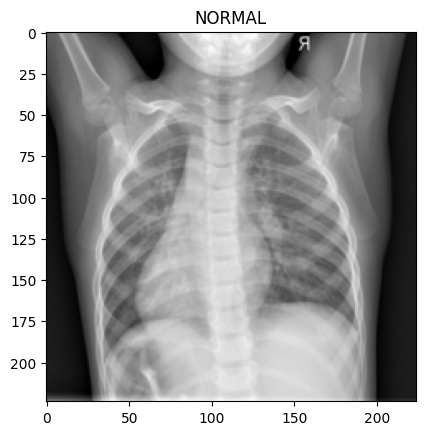

In [51]:
view_img(image, title=train_datasets.classes[label], cmap='gray')

In [52]:
image, label = train_datasets[5000]
print(image) # 이미지
print(label) # 1
print(train_datasets.classes[label]) # PNEUMONIA

tensor([[[0.0000e+00, 2.2410e-01, 8.4365e-01,  ..., 0.0000e+00,
          0.0000e+00, 0.0000e+00],
         [0.0000e+00, 2.2410e-01, 8.4365e-01,  ..., 0.0000e+00,
          0.0000e+00, 0.0000e+00],
         [0.0000e+00, 2.2404e-01, 8.4301e-01,  ..., 0.0000e+00,
          0.0000e+00, 0.0000e+00],
         ...,
         [1.0841e-02, 8.6155e-03, 7.8671e-05,  ..., 7.8594e-05,
          8.6153e-03, 1.0842e-02],
         [1.8764e-01, 1.6593e-02, 9.2624e-05,  ..., 9.2533e-05,
          1.6591e-02, 1.8764e-01],
         [5.5914e-02, 8.4970e-03, 2.8534e-05,  ..., 2.8506e-05,
          8.4965e-03, 5.5913e-02]]])
1
PNEUMONIA


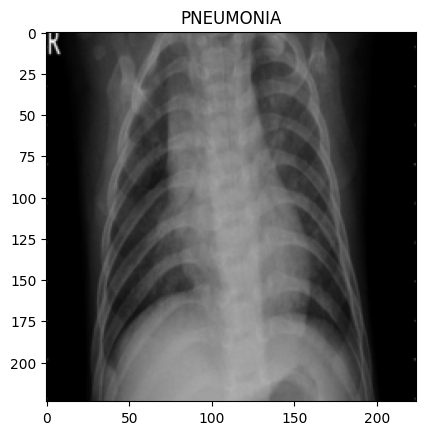

In [53]:
view_img(image, title=train_datasets.classes[label], cmap='gray')

# 2. 데이터 배치사이즈로 분리하기

In [59]:
train_dataLoader = DataLoader(train_datasets, batch_size=4, shuffle=True) 
test_dataLoader = DataLoader(test_datasets, batch_size=4) 

torch.Size([1, 224, 224])
tensor(1)


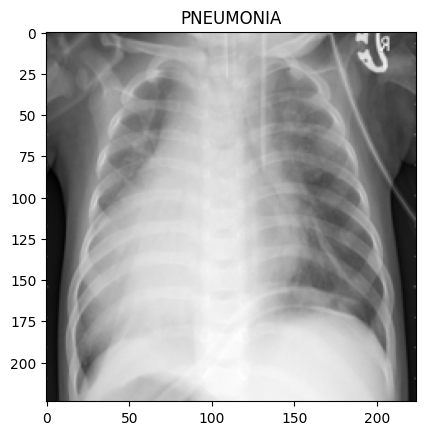

In [60]:
image, label = next(iter(train_dataLoader))
print(image[0].shape)
print(label[0])

view_img(image[0], train_datasets.classes[label[0]], cmap='gray')